In [19]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn import metrics

from yellowbrick.classifier import ROCAUC


In [20]:
#load data
df = pd.read_csv("../datasets/StellarWOWhere.csv")
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237662268080915268,243.498908,4.309792,21.23949,20.39086,20.35097,20.25421,19.90627,3910,301,4,222,5412459332838381568,QSO,2.290692,4807,55687,940
1,1237678439702725272,44.374089,3.017933,25.76758,22.40062,20.49454,19.55738,19.04092,7675,301,6,164,4793200361828800512,GALAXY,0.524215,4257,55480,889
2,1237680122252427770,20.782605,-6.876952,22.40024,22.38897,20.59912,19.78579,19.13067,8067,301,4,107,8061622938980603904,GALAXY,0.517058,7160,56599,653
3,1237654606395474492,150.880031,4.873687,22.33767,21.74014,20.67626,19.84993,19.52213,2126,301,5,212,5404532678417733632,GALAXY,0.657861,4800,55674,775
4,1237678858476388446,11.171527,12.007317,20.22819,20.18983,19.53547,19.50299,19.35294,7773,301,2,383,12432264428896147456,QSO,1.319689,11042,58462,282


In [21]:
#viewing attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      100000 non-null  int64  
 1   ra         100000 non-null  float64
 2   dec        100000 non-null  float64
 3   u          100000 non-null  float64
 4   g          100000 non-null  float64
 5   r          100000 non-null  float64
 6   i          100000 non-null  float64
 7   z          100000 non-null  float64
 8   run        100000 non-null  int64  
 9   rerun      100000 non-null  int64  
 10  camcol     100000 non-null  int64  
 11  field      100000 non-null  int64  
 12  specobjid  100000 non-null  uint64 
 13  class      100000 non-null  object 
 14  redshift   100000 non-null  float64
 15  plate      100000 non-null  int64  
 16  mjd        100000 non-null  int64  
 17  fiberid    100000 non-null  int64  
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 13.7+

In [22]:
#viewing class distribution
df["class"].value_counts()

GALAXY    59673
STAR      21566
QSO       18761
Name: class, dtype: int64

In [23]:
#check null values
df.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

In [24]:
#check duplicates
duplicates = df[df.duplicated(keep=False)] #dataframe of all duplicated entries
print(duplicates.size) #0 duplicates

0


In [25]:
#drop rerun and ID
print(df["rerun"].nunique()) #we see rerun has the same value for all entries
df = df.drop(['rerun','objid','specobjid'], axis=1) #drop specobjid?
df.head()

1


,ra,dec,u,g,r,i,z,run,camcol,field,class,redshift,plate,mjd,fiberid
0,243.498908,4.309792,21.23949,20.39086,20.35097,20.25421,19.90627,3910,4,222,QSO,2.290692,4807,55687,940
1,44.374089,3.017933,25.76758,22.40062,20.49454,19.55738,19.04092,7675,6,164,GALAXY,0.524215,4257,55480,889
2,20.782605,-6.876952,22.40024,22.38897,20.59912,19.78579,19.13067,8067,4,107,GALAXY,0.517058,7160,56599,653
3,150.880031,4.873687,22.33767,21.74014,20.67626,19.84993,19.52213,2126,5,212,GALAXY,0.657861,4800,55674,775
4,11.171527,12.007317,20.22819,20.18983,19.53547,19.50299,19.35294,7773,2,383,QSO,1.319689,11042,58462,282


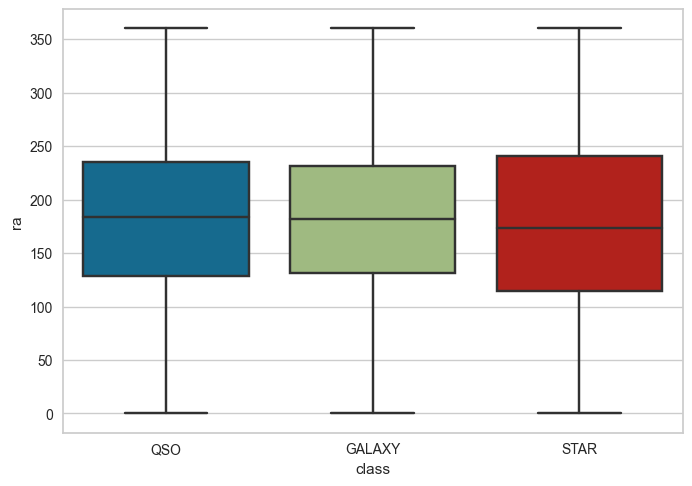

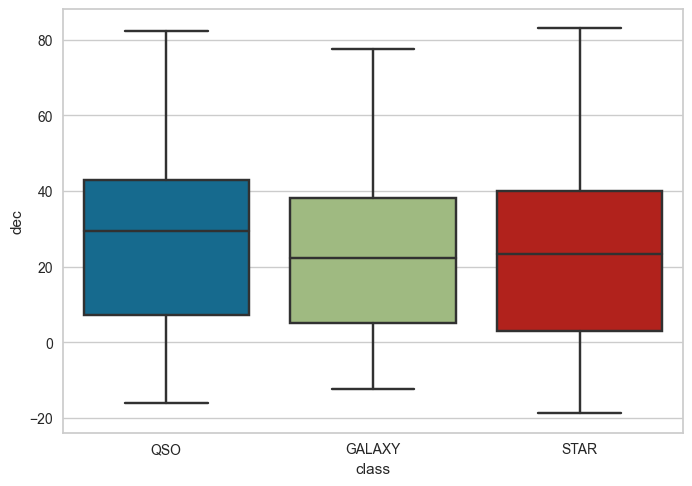

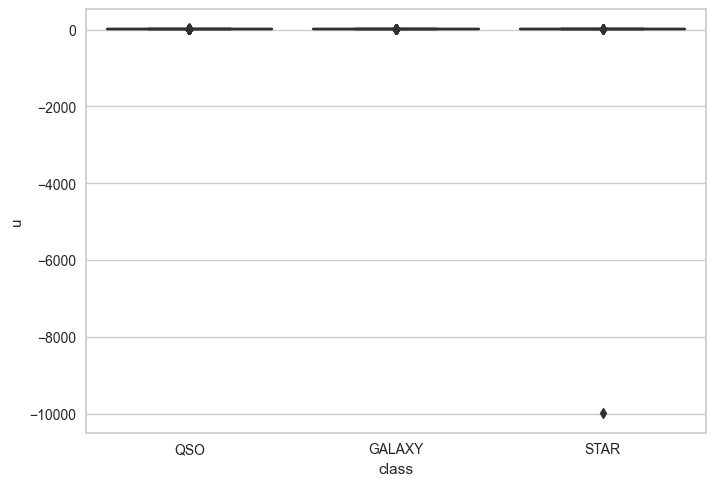

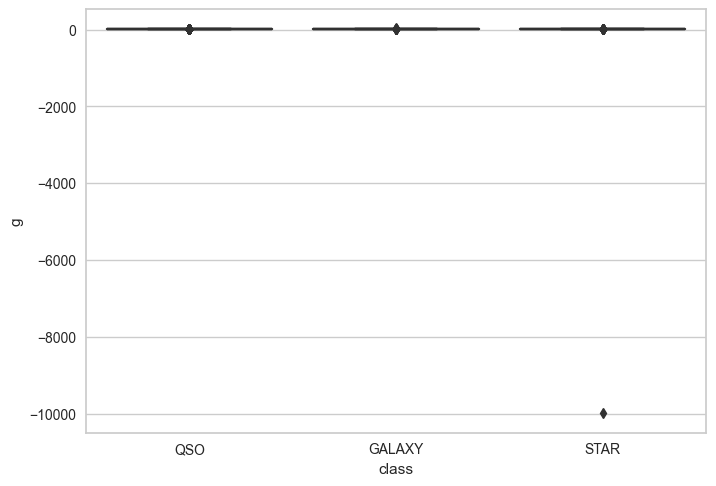

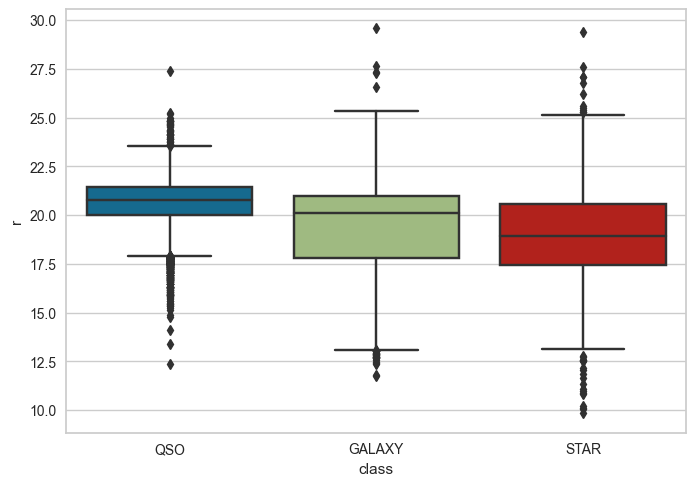

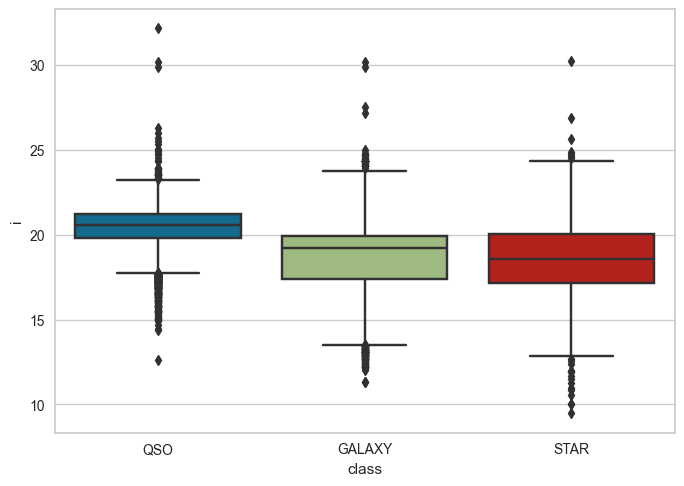

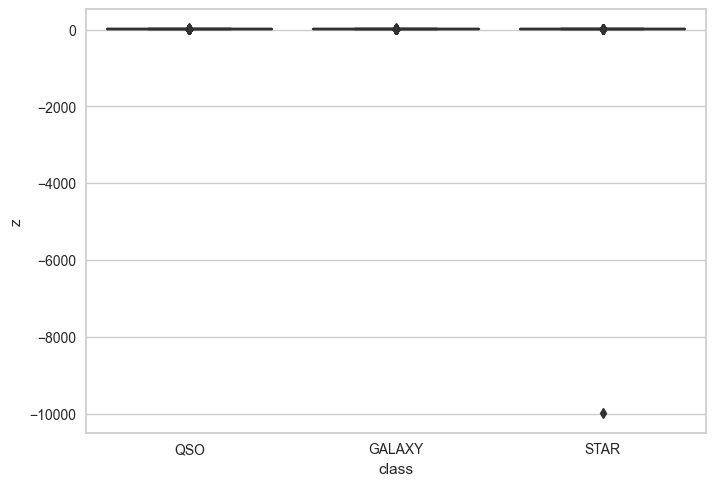

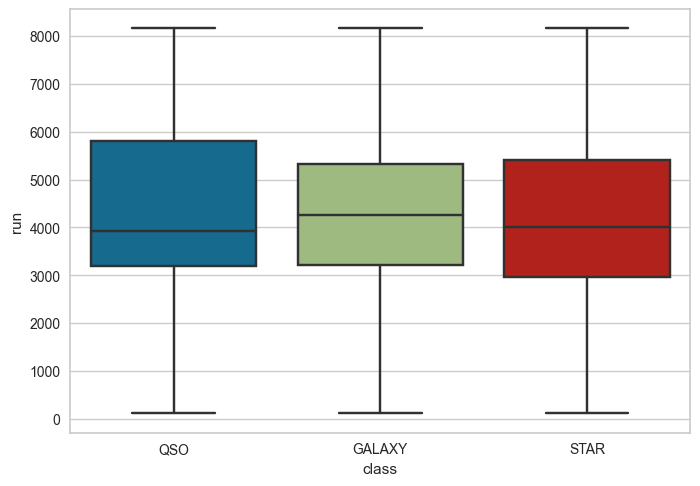

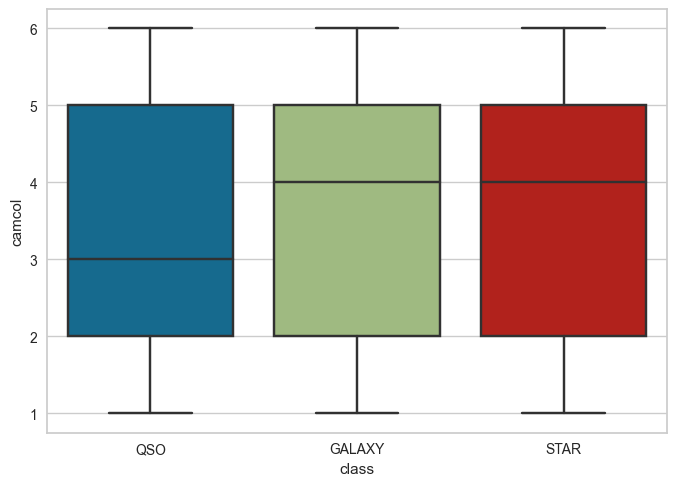

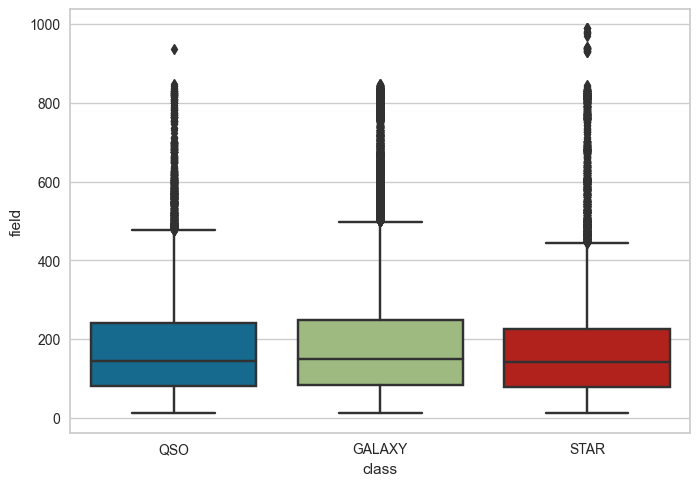

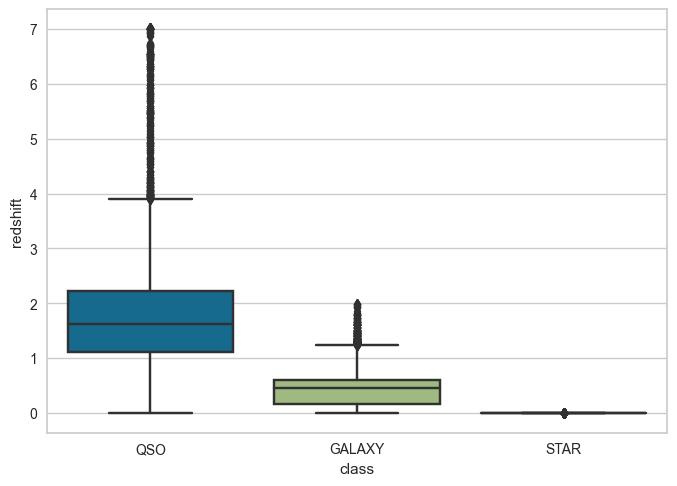

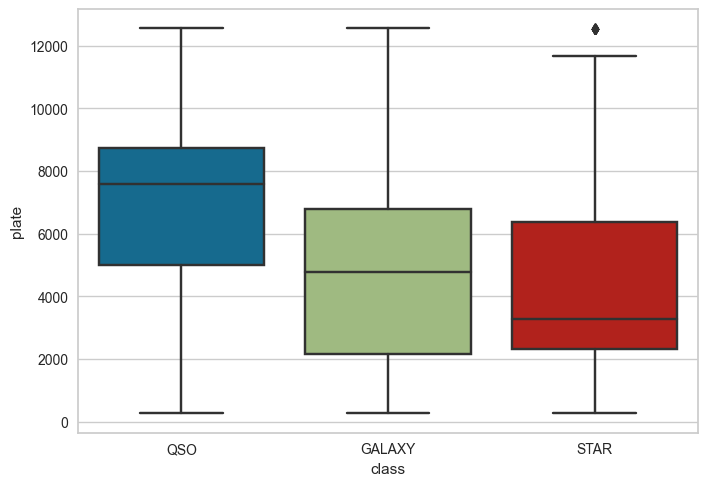

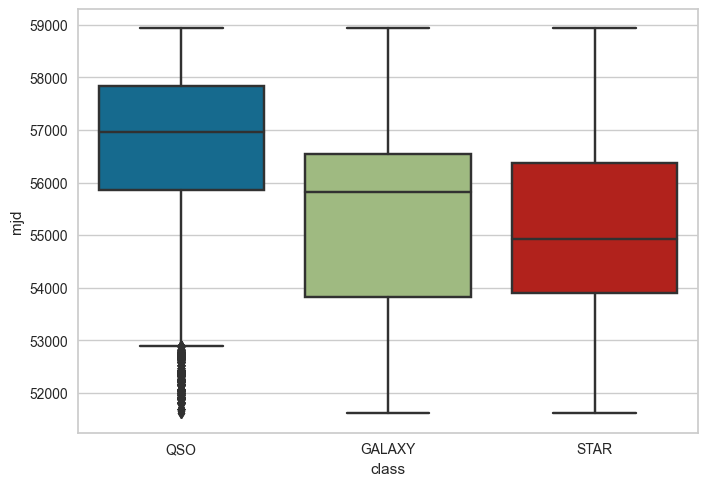

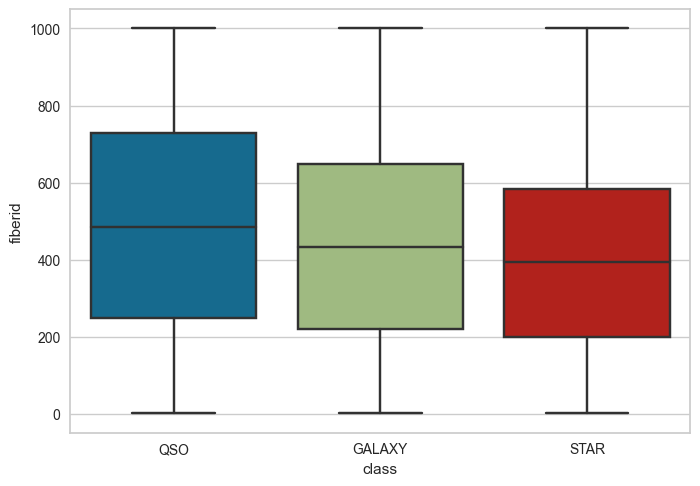

<Figure size 800x550 with 0 Axes>

In [26]:
#visualize data and check for outliers

features= list(df.columns)

for i in range(len(features)):
    if i != 10: #index 11 is the class label
        sns.boxplot(x='class', y=features[i], data=df)
        plt.figure()


In [27]:
#we see an outlier in u, g, and z plots
display(df[df['u'] == min(df['u'])]) #finding the outliers index
df = df.drop(index=[83683]) #dropping the outlier


,ra,dec,u,g,r,i,z,run,camcol,field,class,redshift,plate,mjd,fiberid
83683,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,752,2,537,STAR,0.000089,3314,54970,162


In [28]:
#splitting the class column
y = df["class"]
x = df.drop(["class"], axis=1)

#balance the data
sm = SMOTE(random_state=42)
x, y = sm.fit_resample(x, y)

#scaling data
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [29]:
#PCA - not using anymore
# a = x

# pca = PCA(n_components=10)
# principalComponents = pca.fit_transform(a)

# vals = pca.explained_variance_ratio_
# print(vals)

# #plotting pca variances
# plt.bar([1,2,3,4,5,6,7,8,9,10], height=vals)
# plt.xticks([1,2,3,4,5,6,7,8,9,10], ["PCA1","PCA2","PCA3","PCA4","PCA5","PCA6","PCA7","PCA8","PCA9","PCA10"])
# plt.xlabel('PCA')
# plt.ylabel('Variance')
# plt.title('Variance of PCAs')
# plt.show()

# final = pd.DataFrame(principalComponents)
# final.head()

# sum = 0
# for i in range(10):
#     sum += vals[i]
# print(sum)

In [30]:
#creating training and testing splits of data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 8)

Accuracy: 0.9707295274271032


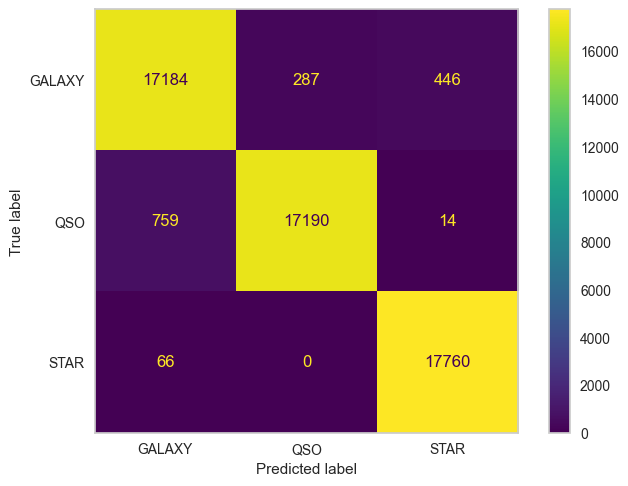

In [31]:
#SUPPORT VECTOR MACHINE CLASSIFICATION

svm = svm.SVC(kernel='rbf')
svm.fit(x_train, y_train) #training the model using training split

score = svm.score(x_test, y_test) #get accuracy using the testing split

print('Accuracy: {}'.format(score))

predictions = svm.predict(x_test) #getting predictions from model using testing split
cm = confusion_matrix(y_test, predictions, labels = svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = svm.classes_)
disp.plot()

plt.grid(False)
plt.show()

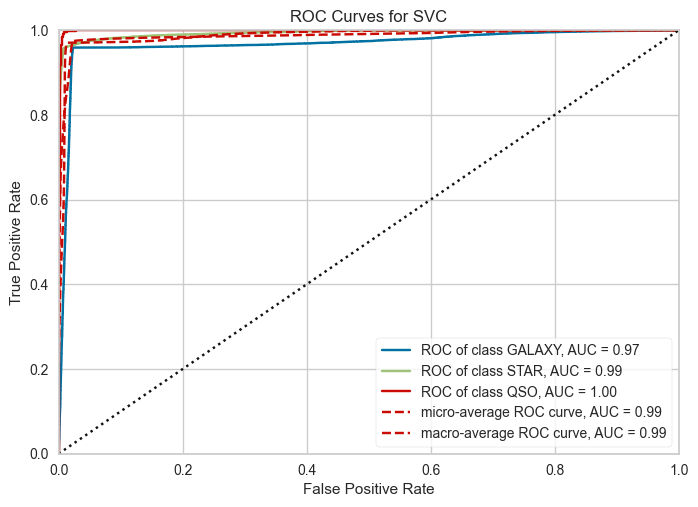

              precision    recall  f1-score   support

      GALAXY       0.95      0.96      0.96     17917
         QSO       0.98      0.96      0.97     17963
        STAR       0.97      1.00      0.99     17826

    accuracy                           0.97     53706
   macro avg       0.97      0.97      0.97     53706
weighted avg       0.97      0.97      0.97     53706



In [32]:
#ROC for SVM
visualizer = ROCAUC(svm, classes=['GALAXY','STAR','QSO'])

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show() 

print(classification_report(y_test, predictions))

Accuracy: 0.9830745168137638


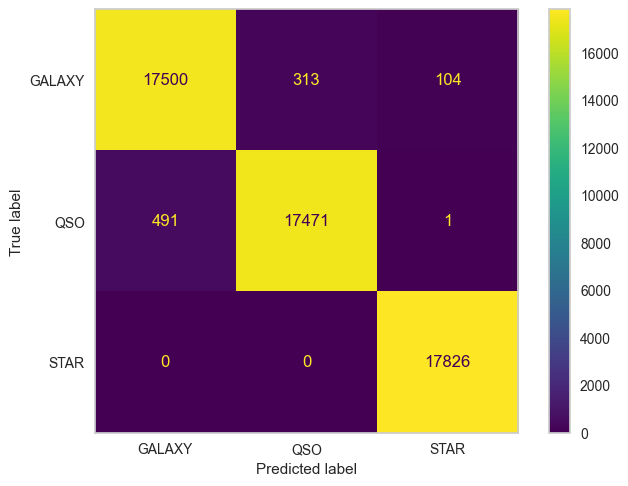

In [33]:
#RANDOM FOREST CLASSIFICATION

rf = RandomForestClassifier()
rf.fit(x_train, y_train) #training the model using training split

score = rf.score(x_test, y_test) #get accuracy using the testing split

print('Accuracy: {}'.format(score))

predictions = rf.predict(x_test) #getting predictions from model using testing split
cm = confusion_matrix(y_test, predictions, labels = rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf.classes_)
disp.plot()

plt.grid(False)
plt.show()

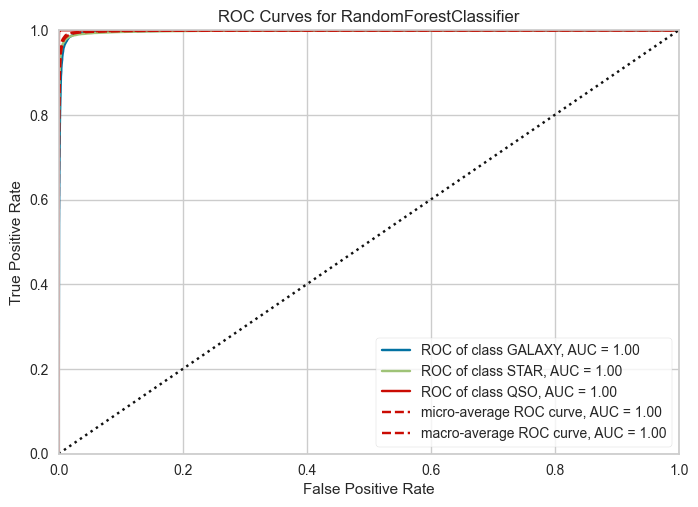

              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     17917
         QSO       0.98      0.97      0.98     17963
        STAR       0.99      1.00      1.00     17826

    accuracy                           0.98     53706
   macro avg       0.98      0.98      0.98     53706
weighted avg       0.98      0.98      0.98     53706



In [34]:
#ROC for Random Forest
visualizer = ROCAUC(rf, classes=['GALAXY','STAR','QSO'])

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show() 

print(classification_report(y_test, predictions))

Accuracy: 0.9714184634863888


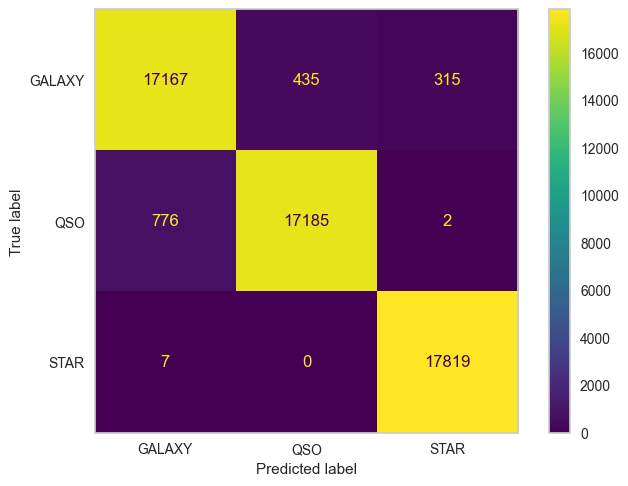

In [35]:
#ARTIFICIAL NEURAL NETWORK CLASSIFICATION

ann = MLPClassifier(hidden_layer_sizes=[5], activation='logistic', max_iter=10000)
ann.fit(x_train, y_train) #training the model using training split

score = ann.score(x_test, y_test) #get accuracy using the testing split

print('Accuracy: {}'.format(score))

predictions = ann.predict(x_test) #getting predictions from model using testing split
cm = confusion_matrix(y_test, predictions, labels = ann.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ann.classes_)
disp.plot()

plt.grid(False)
plt.show()

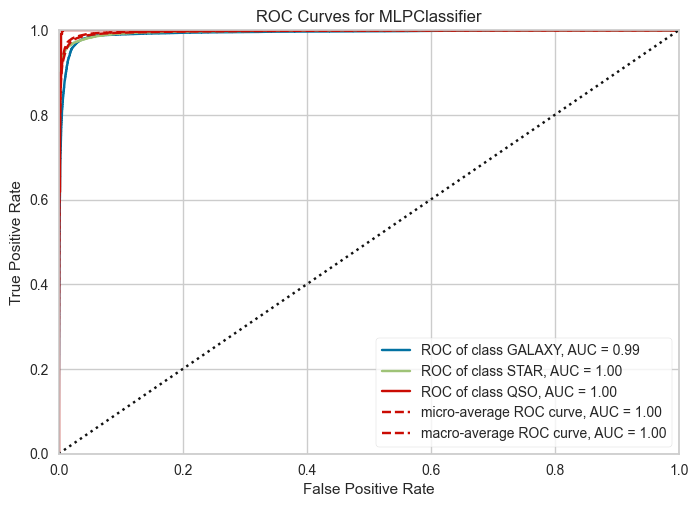

              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     17917
         QSO       0.98      0.96      0.97     17963
        STAR       0.98      1.00      0.99     17826

    accuracy                           0.97     53706
   macro avg       0.97      0.97      0.97     53706
weighted avg       0.97      0.97      0.97     53706



In [36]:
#ROC for ANN
visualizer = ROCAUC(ann, classes=['GALAXY','STAR','QSO'])

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show() 

print(classification_report(y_test, predictions))